<div align = "center">

AML Assignment 2 : SMS Spam Classification Experiment Tracking

Part II - Model Version Control

Trishita Patra

</div>

The notebook does the following :
* Trains and tracks experiments and model versions using MLflow. Trains three models with hyperparameter tuning-
    - Logistic Regression: Interpretable and a strong baseline for linear text classification.
    - Naive Bayes Classifier: A probabilistic model effective on high-dimensional sparse text data.
    - Linear SVM: Maximizes class separation and often achieves high performance in text classification tasks.
    - Feature extraction: Raw text is converted into numerical features using TF-IDF (Term Frequency–Inverse Document Frequency). The `TfidfVectorizer` is embedded within a scikit-learn `Pipeline`, ensuring that feature extraction is learned from the training data and consistently applied to validation and test sets during model training and evaluation.
      - TF-IDF (Term Frequency–Inverse Document Frequency) converts text into numerical features by weighting words based on their importance within a document and across the corpus, emphasizing discriminative terms while downweighting common ones.
      - Unigram TF-IDF offers a strong baseline with lower dimensionality and sparsity, enabling efficient training and better generalization for linear models compared to higher-order n-grams.
* Builds, tunes, and registers three benchmark text-classification models.
* Compares models using AUCPR and selects the best-performing benchmark.
    - `Area Under the Precision–Recall Curve (AUCPR)` measures how well a model identifies the positive class, especially when data is imbalanced.
* Enables versioned retrieval and evaluation of registered models across experiments.




### Required Libraries

In [13]:
!pip install -q mlflow

In [14]:
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

### Upload Data

We are procceeding with latest data split corresponsing to `seed = 123`.

In [15]:
from google.colab import files
uploaded = files.upload()

Saving validation.csv to validation (1).csv
Saving train.csv to train (1).csv
Saving test.csv to test (1).csv


### Helper Functions

In [19]:
# Load dataset splits
def load_split(file_path: str) -> pd.DataFrame:
    return pd.read_csv(file_path)

# Fit model to training data
def fit_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# AUCPR Metric
def compute_aucpr(y_true, y_scores):
    return average_precision_score(y_true, y_scores)

# Evaluate model with multiple metrics
def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)
    }
# Build model
def build_model(model_name, param):

    if model_name == "LogisticRegression":
        clf = LogisticRegression(C=param, max_iter=1000)

    elif model_name == "NaiveBayes":
        clf = MultinomialNB(alpha=param)

    elif model_name == "LinearSVM":
        clf = LinearSVC(C=param)

    else:
        raise ValueError("Unknown model")

    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english")),
        ("clf", clf)
    ])

    return pipeline
# Hyperparameter tuning using GridSearchCV | F1 Score on validation set
def tune_and_evaluate_model(
    model_name,
    param_values,
    X_train, y_train,
    X_val, y_val
):
    records = []

    for param in param_values:
        if model_name == "LogisticRegression":
            model = Pipeline([
                ("tfidf", TfidfVectorizer()),
                ("clf", LogisticRegression(C=param, max_iter=1000))
            ])

        elif model_name == "NaiveBayes":
            model = Pipeline([
                ("tfidf", TfidfVectorizer()),
                ("clf", MultinomialNB(alpha=param))
            ])

        elif model_name == "LinearSVM":
            model = Pipeline([
                ("tfidf", TfidfVectorizer()),
                ("clf", LinearSVC(C=param))
            ])

        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        train_metrics = compute_metrics(y_train, train_pred)
        val_metrics = compute_metrics(y_val, val_pred)

        records.append({
            "param": param,
            **{f"train_{k}": v for k, v in train_metrics.items()},
            **{f"val_{k}": v for k, v in val_metrics.items()},
            "model": model
        })

    df = pd.DataFrame(records)

    best_row = df.loc[df["val_f1"].idxmax()]
    best_model = best_row["model"]

    return df, best_model, best_row

### Training and Evaluation

In [20]:
# -------- Load data --------
train_df = load_split("train.csv")
val_df = load_split("validation.csv")
test_df = load_split("test.csv")

X_train, y_train = train_df["text"], train_df["label"]
X_val, y_val = val_df["text"], val_df["label"]
X_test, y_test = test_df["text"], test_df["label"]

model_configs = {
    "LogisticRegression": [0.1, 0.5, 1, 5, 10],
    "NaiveBayes": [0.1, 0.5, 1.0, 1.5, 2.0],
    "LinearSVM": [0.1, 0.5, 1, 5, 10]
}

best_models = {}

# -------- Hyperparameter tuning --------
print("\n===== Hyperparameter Tuning =====")

for model_name, param_values in model_configs.items():

    best_f1 = -1
    best_model = None
    best_param = None

    print(f"\n{model_name}")

    for param in param_values:

        model = build_model(model_name, param)
        model.fit(X_train, y_train)

        val_pred = model.predict(X_val)
        val_metrics = compute_metrics(y_val, val_pred)

        print(f"  Param={param:<4} | Val F1={val_metrics['f1']:.4f}")

        if val_metrics["f1"] > best_f1:
            best_f1 = val_metrics["f1"]
            best_model = model
            best_param = param

    best_models[model_name] = best_model
    print(f"  → Selected Param={best_param} (F1={best_f1:.4f})")

# -------- MLflow tracking --------
mlflow.set_experiment("sms_spam_models")

test_metrics_summary = {}

print("\n===== Experiment Tracking & Model Versioning =====")

for model_name, model in best_models.items():

    with mlflow.start_run(run_name=model_name):

        test_pred = model.predict(X_test)
        test_metrics = compute_metrics(y_test, test_pred)

        if hasattr(model, "decision_function"):
            test_scores = model.decision_function(X_test)
        else:
            test_scores = model.predict_proba(X_test)[:, 1]

        aucpr = compute_aucpr(y_test, test_scores)

        mlflow.log_metrics(test_metrics)
        mlflow.log_metric("test_aucpr", aucpr)

        mlflow.sklearn.log_model(
            model,
            artifact_path=model_name,
            registered_model_name=model_name
        )

        test_metrics_summary[model_name] = {
            **test_metrics,
            "aucpr": aucpr
        }

        print(f"{model_name} registered | AUCPR={aucpr:.4f}")

# -------- Final comparison --------
print("\n===== Final Model Comparison =====")

best_model_name = max(
    test_metrics_summary,
    key=lambda m: test_metrics_summary[m]["aucpr"]
)

for model, metrics in test_metrics_summary.items():
    print(f"{model:<20} AUCPR={metrics['aucpr']:.4f}")

print(f"\nSelected Best Model: {best_model_name}")



===== Hyperparameter Tuning =====

LogisticRegression
  Param=0.1  | Val F1=0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Param=0.5  | Val F1=0.6471
  Param=1    | Val F1=0.8144
  Param=5    | Val F1=0.9202
  Param=10   | Val F1=0.9252
  → Selected Param=10 (F1=0.9252)

NaiveBayes
  Param=0.1  | Val F1=0.9148
  Param=0.5  | Val F1=0.9126
  Param=1.0  | Val F1=0.8687
  Param=1.5  | Val F1=0.8211
  Param=2.0  | Val F1=0.7760
  → Selected Param=0.1 (F1=0.9148)

LinearSVM
  Param=0.1  | Val F1=0.8442
  Param=0.5  | Val F1=0.9352
  Param=1    | Val F1=0.9401
  Param=5    | Val F1=0.9406


2026/02/16 09:11:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  Param=10   | Val F1=0.9406
  → Selected Param=5 (F1=0.9406)

===== Experiment Tracking & Model Versioning =====


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'LogisticRegression' already exists. Creating a new version of this model...
Created version '5' of model 'LogisticRegression'.
2026/02/16 09:11:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommende

LogisticRegression registered | AUCPR=0.9736


Registered model 'NaiveBayes' already exists. Creating a new version of this model...
Created version '5' of model 'NaiveBayes'.
2026/02/16 09:11:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


NaiveBayes registered | AUCPR=0.9728


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


LinearSVM registered | AUCPR=0.9769

===== Final Model Comparison =====
LogisticRegression   AUCPR=0.9736
NaiveBayes           AUCPR=0.9728
LinearSVM            AUCPR=0.9769

Selected Best Model: LinearSVM


Registered model 'LinearSVM' already exists. Creating a new version of this model...
Created version '5' of model 'LinearSVM'.


### Visualizating Hyperparameter Tuning (Out of the scope of this assignment)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


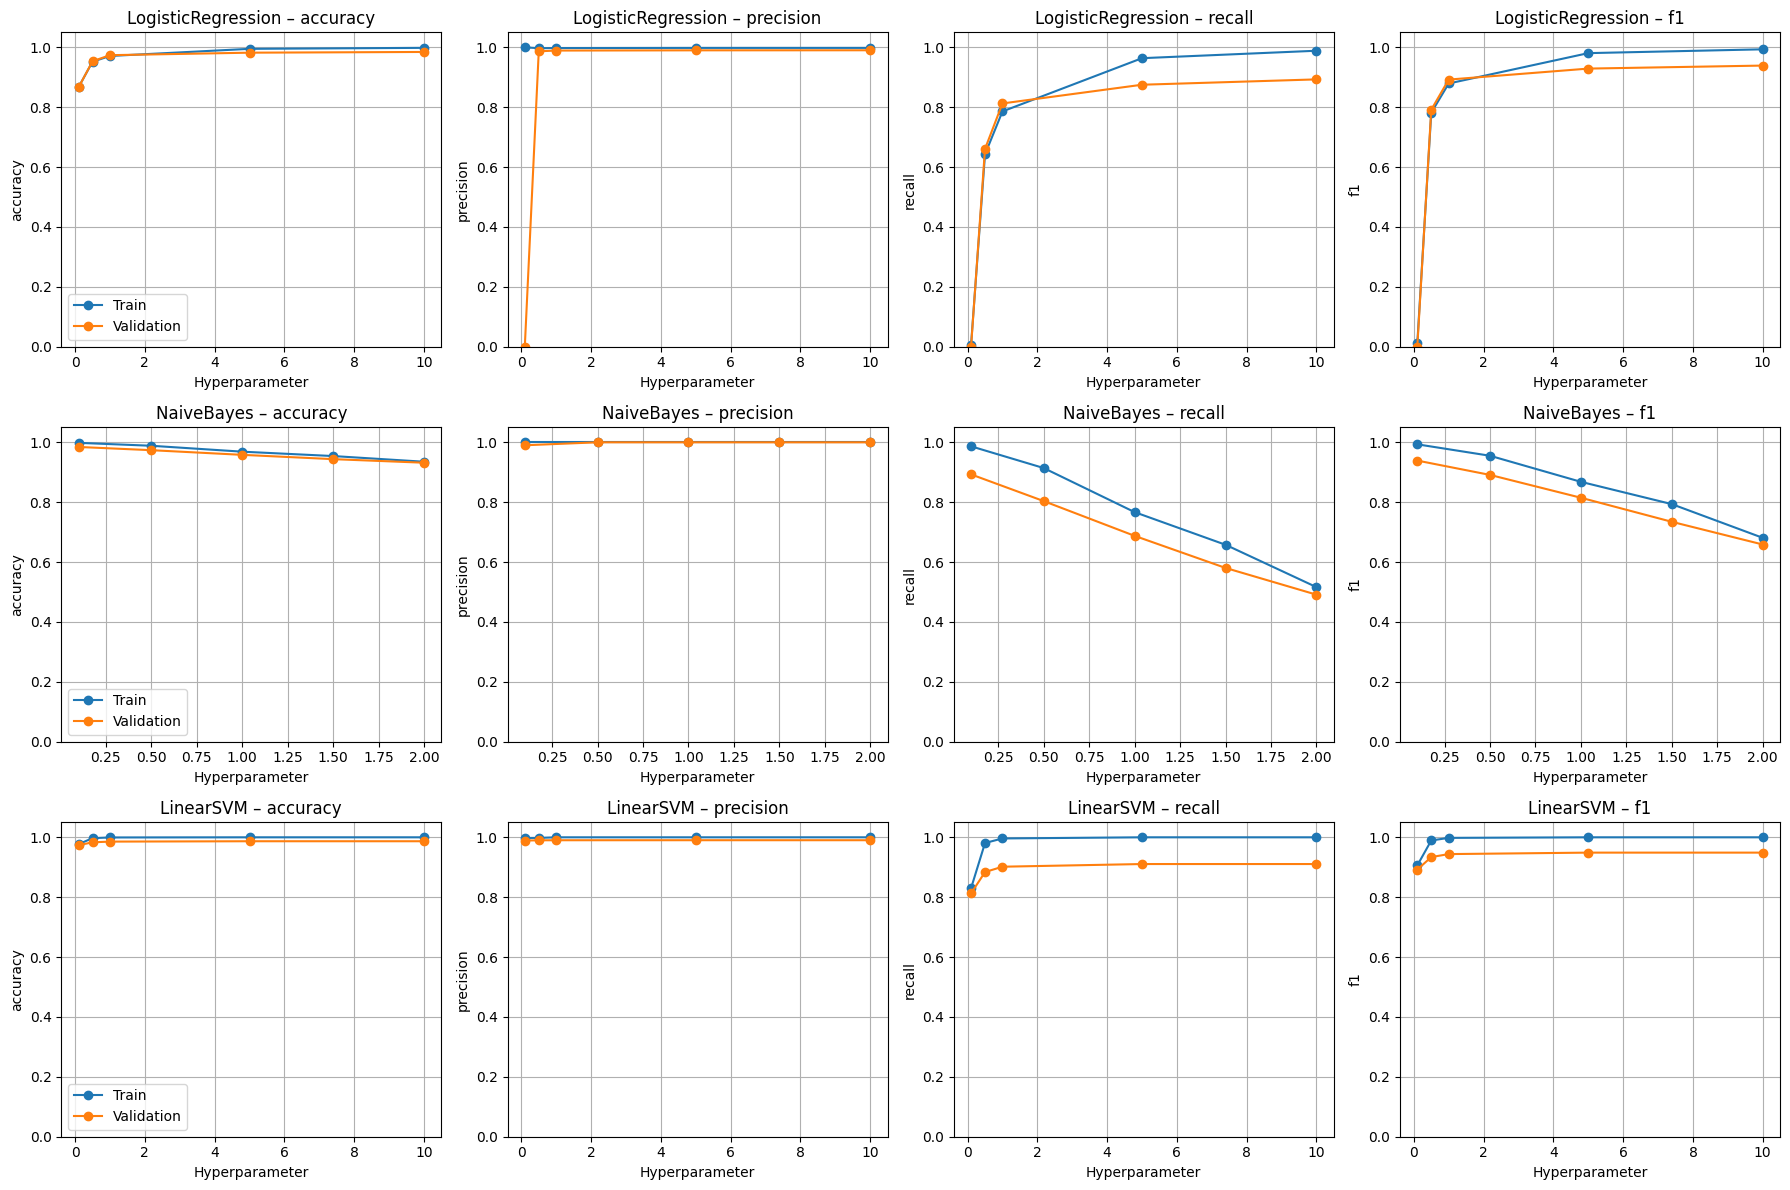

In [21]:
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
metrics = ["accuracy", "precision", "recall", "f1"]

for row_idx, (model_name, params) in enumerate(model_configs.items()):
        df, best_model, best_row = tune_and_evaluate_model(
            model_name, params, X_train, y_train, X_val, y_val
        )

        model_results[model_name] = df
        best_models[model_name] = best_model

        for col_idx, metric in enumerate(metrics):
            ax = axes[row_idx, col_idx]

            ax.plot(df["param"], df[f"train_{metric}"], label="Train", marker="o")
            ax.plot(df["param"], df[f"val_{metric}"], label="Validation", marker="o")

            ax.set_title(f"{model_name} – {metric}")
            ax.set_xlabel("Hyperparameter")
            ax.set_ylabel(metric)
            ax.set_ylim(0, 1.05)
            ax.grid(True)

            if col_idx == 0:
                ax.legend()

plt.tight_layout()
plt.show()


- Logistic Regression: At low values of the hyperparameter, the model underfits and misses spam (low recall); increasing it improves recall and F1 until performance stabilizes, with no strong signs of overfitting (plateau).
- Naive Bayes: Higher smoothing leads to underfitting, causing recall and F1 to drop because the model becomes too conservative in predicting spam.
- Linear SVM: Achieves high performance quickly and shows minimal train–validation gap, indicating good generalization.
- Precision is consistently high because the dataset is imbalanced (only ~13% spam), so models are cautious about predicting the minority class, leading to very few false positives but making recall the main challenge.